# 第8章: 機械学習
本章では，Bo Pang氏とLillian Lee氏が公開している[Movie Review Data](http://www.cs.cornell.edu/people/pabo/movie-review-data/)の[sentence polarity dataset v1.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.README.1.0.txt)を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

# 70. データの入手・整形

[文に関する極性分析の正解データ](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz)を用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
2. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
3. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

### データ確認

In [1]:
!wc -l "data/rt-polaritydata/rt-polarity.pos"
!wc -l "data/rt-polaritydata/rt-polarity.neg"

5331 data/rt-polaritydata/rt-polarity.pos
5331 data/rt-polaritydata/rt-polarity.neg


In [2]:
!nkf -g "data/rt-polaritydata/rt-polarity.pos"

BINARY


In [3]:
import chardet
with open('data/rt-polaritydata/rt-polarity.pos', 'rb') as f:
    print(chardet.detect(f.read()))

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


### 加工

In [4]:
# utf-8に変換
with open('data/rt-polaritydata/rt-polarity.pos', 'rb') as fi, open('work/utf8.pos', 'w') as fo:
        fo.write(fi.read().decode('Windows-1252'))
    
with open('data/rt-polaritydata/rt-polarity.neg', 'rb') as fi,open('work/utf8.neg', 'w') as fo:
        fo.write(fi.read().decode('Windows-1252'))

In [5]:
!sed -r 's/^/+1 /g' "work/utf8.pos" > "work/labeled.pos"
!sed -r 's/^/-1 /g' "work/utf8.neg" > "work/labeled.neg"
!paste -d '\n' "work/labeled.pos" "work/labeled.neg" | shuf > "work/sentiment.txt"

### 確認

In [6]:
!head "work/sentiment.txt"

+1 proves that some movie formulas don't need messing with -- like the big-bug movie . 
-1 the film never rises above a conventional , two dimension tale
-1 the slapstick is labored , and the bigger setpieces flat . 
-1 despite its dry wit and compassion , the film suffers from a philosophical emptiness and maddeningly sedate pacing . 
-1 director dirk shafer and co-writer greg hinton ride the dubious divide where gay porn reaches for serious drama . 
+1 aniston has at last decisively broken with her friends image in an independent film of satiric fire and emotional turmoil . 
-1 represents the depths to which the girls-behaving-badly film has fallen . 
+1 you might not buy the ideas . but you'll definitely want the t-shirt . 
-1 martin scorsese cria um espetáculo visual que não possui alma - um filme esteticamente belo , mas emocionalmente frio . 
+1 very well written and directed with brutal honesty and respect for its audience . 


In [7]:
!grep -c '^\+1' 'work/sentiment.txt'
!grep -c '^\-1' 'work/sentiment.txt'

5331
5331


### memo

iconv, nkf で utf-8 に 変換できる  
nkfは1行消滅するバグ...?

# 71. ストップワード

英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

### stop words の作成

In [1]:
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/ryuto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 関数作成

In [3]:
def is_stopwords(word):
    return word in stopWords

### テスト

In [4]:
sent = "this version's no classic like its predecessor , but its pleasures are still plentiful . "

In [5]:
words = sent.strip().split()
for word in words:
    print("{} : {}".format(word, is_stopwords(word)))

this : True
version's : False
no : True
classic : False
like : False
its : True
predecessor : False
, : False
but : True
its : True
pleasures : False
are : True
still : False
plentiful : False
. : False


### memo
stop words の数 nltk (318) > sklearn (179)  
!pytest () : test〜.pyのtest〜関数を全部実行してくれるモジュール  

# 72. 素性抽出

極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [6]:
import string

In [7]:
def get_feature(sent):
    stemmer = nltk.stem.PorterStemmer()
    words = [word.strip(string.punctuation) for word in sent.split()]
    # remove stopwords
    not_stopwords = [word for word in words if word and not is_stopwords(word)]
    # stemming
    stems = [stemmer.stem(word).strip(string.punctuation) for word in not_stopwords]
    
    return ' '.join(stems)

In [8]:
print("raw : {}".format(sent))
print("feature : {}".format(get_feature(sent)))

raw : this version's no classic like its predecessor , but its pleasures are still plentiful . 
feature : version classic like predecessor pleasur still plenti


### memo
^  
- lower をかける
- 毎回stemmerを呼び出しているのがよくなさそう  
- for で 3回 まわすより、1回 の for で 処理できるのでは...?

### 修正ver

In [9]:
def get_feature1(sent, stemmer):
    return ' '.join(stemmer.stem(word).strip(string.punctuation)
                    for word in sent.split()
                    if word not in string.punctuation and not is_stopwords(word))

In [10]:
stemmer = nltk.stem.PorterStemmer()
print("raw : {}".format(sent))
print("feature : {}".format(get_feature1(sent, stemmer)))

raw : this version's no classic like its predecessor , but its pleasures are still plentiful . 
feature : version classic like predecessor pleasur still plenti


# 73. 学習

72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

https://scikit-learn.org/stable/modules/feature_extraction.html

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

### データ処理時間の比較
- 処理時間を計測したら同じくらいだった(about 3.15s)

In [12]:
# パターン1
with open("work/sentiment.txt") as f:
    x_features = [get_feature1(line.split(' ', 1)[1], stemmer) for line in f]
    y_labels = [line.split(' ', 1)[0] for line in f]

In [13]:
# パターン2
x_features = []
y_labels = []
with open("work/sentiment.txt") as f:
    for line in f:
        label, sent = line.split(' ', 1)
        x_features.append(get_feature1(sent, stemmer))
        y_labels.append(label)

### ロジスティック回帰

In [14]:
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(x_features)
ys_gold = np.array(y_labels)

In [15]:
print(xs.shape)
print(ys_gold.shape)

(10662, 13381)
(10662,)


In [16]:
clf = LogisticRegression()
clf.fit(xs, ys_gold)

/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# 74. 予測

73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
def predict_label(clf, xs):
    # 10662 × 2
    proba = clf.predict_proba(xs)
    
    # 2dim において maxの値とindexを取得
    scores = proba.max(axis=1)
    inds = proba.argmax(axis=1)
    
    labels = clf.classes_[inds]
    
    return labels, scores

In [18]:
predict_label(clf, xs)

(array(['-1', '-1', '-1', ..., '+1', '-1', '-1'], dtype='<U2'),
 array([0.80743024, 0.71010371, 0.9290568 , ..., 0.98718363, 0.85677988,
        0.84837827]))

### memo
bug of wordsは意外と強い

# 75. 素性の重み

73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [19]:
# 1 × 13381 (feature) の 重みvec
clf.coef_.shape

(1, 13381)

In [20]:
# 重みが低い -> 高い順に indexをソート
feature_inds = clf.coef_[0].argsort()
low_inds = feature_inds[:10]
high_inds = feature_inds[-10:][::-1]

# featureを取り出す (indsで一気に取り出せるように ndarrayへ)
feature_names = np.array(vectorizer.get_feature_names())

In [21]:
# 重みの高い素性トップ10
feature_names[high_inds]

array(['bore', 'dull', 'neither', 'fail', 'plod', 'mediocr', 'routin',
       'wast', 'badli', 'junk'], dtype='<U17')

In [22]:
# 重みの低い素性トップ10
feature_names[low_inds]

array(['engross', 'refresh', 'unexpect', 'smarter', 'resist', 'warm',
       'refreshingli', 'examin', 'remark', 'solid'], dtype='<U17')

# 76. ラベル付け

学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [23]:
from itertools import islice

In [24]:
ys_pred, ys_score = predict_label(clf, xs) # 74

print('正解', '   予測', '          確率')
for y_gold, y_pred, score in islice(zip(ys_gold, ys_pred, ys_score), 10):
    print(y_gold, y_pred, score, sep='\t')

正解    予測           確率
+1	-1	0.807430237718231
-1	-1	0.7101037071239211
-1	-1	0.9290567997679101
-1	-1	0.9351765097624752
-1	-1	0.8452275031815152
+1	+1	0.6039056227190196
-1	-1	0.8954602066837926
+1	-1	0.7342936495413078
-1	-1	0.9104699671181301
+1	+1	0.8941535688082174


### pandas使った方が綺麗かも

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame(((g, p, s) for g, p, s in zip(ys_gold, ys_pred, ys_score)), columns=['正解', '予測', '確率'])
df[:10]

,正解,予測,確率
0,+1,-1,0.807430
1,-1,-1,0.710104
2,-1,-1,0.929057
3,-1,-1,0.935177
4,-1,-1,0.845228
5,+1,+1,0.603906
6,-1,-1,0.895460
7,+1,-1,0.734294
8,-1,-1,0.910470
9,+1,+1,0.894154


### 正解率 (train-train での accuracy)

In [27]:
sum(1 for _ in df['正解'] == df['予測'] if _) / len(df)

0.9444757081223035

### memo

python3での関数アノテーション

関数名 (引数名 : 引数の型=default) -> returnの型:

ex)
def get_hoge(x:str, y:int=3)->str:

# 77. 正解率の計測

76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

### まずは手動

In [28]:
def evaluator(ys_pred, ys_gold, label):
    # 確認
    assert len(ys_pred) == len(ys_gold)
    
    correct = 0
    pred_posi, gold_posi, corr_posi = 0, 0, 0 
    
    for y_pred, y_gold in zip(ys_pred, ys_gold):
        # accuracy の分子
        if y_pred == y_gold:
            correct += 1
            
        # precision の分母
        if y_pred == label:
            pred_posi += 1
            
        # recall の分母
        if y_gold == label:
            gold_posi += 1
            
        # precision、recall の分子
        if y_pred == label and y_gold == label:
            corr_posi += 1
            
    accuracy = correct / len(ys_pred)
    precision = corr_posi / pred_posi
    recall = corr_posi / gold_posi
    f1 = 2 * precision * recall / (precision + recall)
    
    return accuracy, precision, recall, f1

In [29]:
def print_scores(acc, prec, rec, f1):
    print("accuracy : {}".format(acc))
    print("precision : {}".format(prec))
    print("recall : {}".format(rec))
    print("f1 : {}".format(f1))

In [30]:
acc, prec, recall, f1 = evaluator(ys_pred, ys_gold, '+1')

In [31]:
print_scores(acc, prec, recall, f1)

accuracy : 0.9444757081223035
precision : 0.9483443708609272
recall : 0.9401613205777528
f1 : 0.944235116804823


### sklearn metrics

In [32]:
from sklearn import metrics

In [33]:
def evaluator(ys_pred, ys_gold):
    acc = metrics.accuracy_score(ys_gold, ys_pred)
    prec, recall, f1, _ = metrics.precision_recall_fscore_support(ys_gold, ys_pred, labels=['+1', '-1'])
    
    return acc, prec, recall, f1

In [34]:
acc, prec, recall, f1 = evaluator(ys_pred, ys_gold)

In [35]:
print_scores(acc, prec[0], recall[0], f1[0])

accuracy : 0.9444757081223035
precision : 0.9483443708609272
recall : 0.9401613205777528
f1 : 0.944235116804823


# 78. 5分割交差検定

76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [36]:
from sklearn.model_selection import cross_validate
from collections import defaultdict

In [37]:
# ys を index に
label2index = defaultdict(lambda:len(label2index))
ys = np.array([label2index[y] for y in y_labels])

In [38]:
# 5分割交差検定
cv_results = cross_validate(LogisticRegression(), xs, ys, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
# 結果
print_scores(cv_results['test_accuracy'], cv_results['test_precision'], cv_results['test_recall'], cv_results['test_f1'])

accuracy : [0.74086223 0.74437148 0.75703565 0.7532833  0.76031895]
precision : [0.73406193 0.74598678 0.75183824 0.75665399 0.76555024]
recall : [0.75538894 0.74108818 0.7673546  0.7467167  0.75046904]
f1 : [0.74457275 0.74352941 0.75951718 0.7516525  0.75793463]


### 手動

In [40]:
from sklearn.model_selection import train_test_split
from collections import deque

In [41]:
def handmade_cross_validate(xs, ys, cv=5):
    xs_que = deque(np.array_split(xs.toarray(), cv, axis=0))
    ys_que = deque(np.array_split(ys, cv, axis=0))
    evaluation = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
    
    for _ in range(cv):
        # データ取り出し
        xs_test = xs_que.popleft()
        ys_test = ys_que.popleft()
        xs_train = np.concatenate(xs_que)
        ys_train = np.concatenate(ys_que)
        
        # fit (学習)
        clf = LogisticRegression()
        clf.fit(xs_train, ys_train)

        # test
        ys_test_pred, _ = predict_label(clf, xs_test)

        # 評価
        acc, prec, recall, f1 = evaluator(ys_test_pred, ys_test)
        
        # 記録
        evaluation['accuracy'].append(acc)
        evaluation['precision'].append(sum(prec) / len(prec))
        evaluation['recall'].append(sum(recall) / len(recall))
        evaluation['f1'].append(sum(f1) / len(f1))
        
        # データを元に戻す
        xs_que.append(xs_test)
        ys_que.append(ys_test)
        
    return evaluation

In [42]:
# 5分割交差検定
cv_results = handmade_cross_validate(xs, ys_gold)

/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
# 結果
print_scores(cv_results['accuracy'], cv_results['precision'], cv_results['recall'], cv_results['f1'])

accuracy : [0.739803094233474, 0.7430848570089077, 0.7575046904315197, 0.7551594746716698, 0.7603189493433395]
precision : [0.7400308813049331, 0.7431062345911308, 0.757697098814612, 0.7552171341669482, 0.7604300626635577]
recall : [0.7398637421070122, 0.7430869984930835, 0.7576197617438324, 0.7552090483784097, 0.7603720782878063]
f1 : [0.7397701485981993, 0.7430802829606419, 0.7574982349911545, 0.75515925921037, 0.7603125688210445]


### memo
# 正解ラベルが正が多数の場合はF1ではなく、マシューズ相関係数で評価した方が良い

# 79. 適合率-再現率グラフの描画

ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

- memo : perdict positive を rank順に並べる

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [45]:
# 2/3 , 1/3 と分割
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

# 学習
clf = LogisticRegression()
clf.fit(xs_train, ys_train)

# predict
ys_test_pred = clf.predict_proba(xs_test)

/Users/ryuto/.pyenv/versions/anaconda3-5.2.0/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
# 確認
print(label2index, clf.classes_)

defaultdict(<function <lambda> at 0x1137147b8>, {'+1': 0, '-1': 1}) [0 1]


In [47]:
# precision_recall_curve
precision, recall, threshold = precision_recall_curve(ys_test, ys_test_pred[:,0], pos_label=0)

Text(0.5, 1.0, 'Precision-Recall curve')

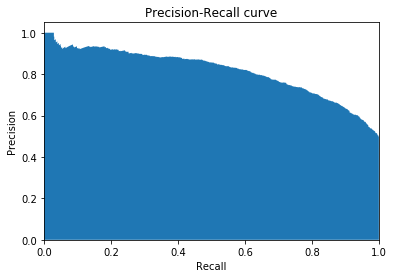

In [48]:
# plot
plt.fill_between(recall, precision)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')